In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g76AQ69ukgWw7b2TchkF1knSdLl1XobpuI3S8bNZOHrbQvNVGSTmV8
Mounted at /content/drive


In [ ]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
import PIL.Image as image
import numpy as np
import jieba
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# import train csv and test csv
train_df = pd.read_csv("/content/drive/My Drive/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/test.csv")

In [ ]:
# Convert to string 
train_df.summary = train_df.summary.astype(str)
train_df.reviewText = train_df.reviewText.astype(str)
test_df.summary = test_df.summary.astype(str)
test_df.reviewText = test_df.reviewText.astype(str)

## Exploratory Data Analysis 

In [ ]:
fiveStar_percent = (train_df[train_df['overall']==5].groupby('category')['overall'].count()/ train_df.groupby('category')['category'].count()).values

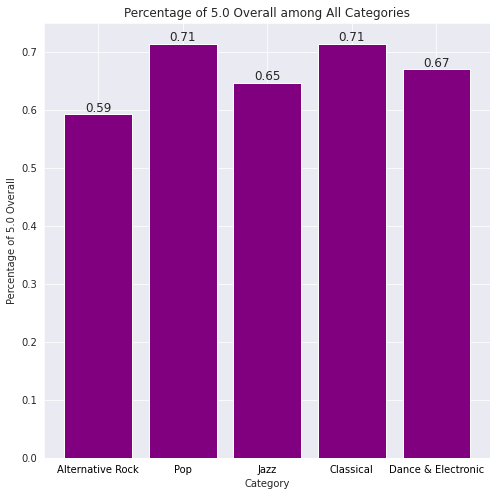

In [ ]:
# Percent of five star ratings in each category
plt.figure(figsize=(8,8))
plt.bar([i for i in range(5)], fiveStar_percent, width = 0.8, color = "purple")
plt.xticks([i for i in range(5)],["Alternative Rock","Pop","Jazz","Classical","Dance & Electronic"],color = "black",rotation = 0)
plt.xlabel("Category")
plt.ylabel("Percentage of 5.0 Overall")
plt.title("Percentage of 5.0 Overall among All Categories")
for a,b in zip([i for i in range(5)], fiveStar_percent):  
    plt.text(a,b,'%.2f'%b,ha='center',va='bottom',fontsize=12);
plt.show()

No handles with labels found to put in legend.


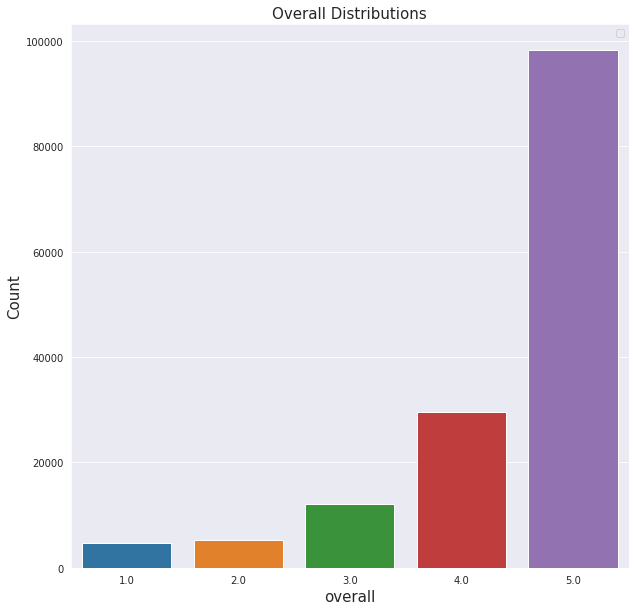

In [ ]:
# Rating distribution 
fig = plt.subplots(figsize=(10,10))
sns.countplot('overall', data=train_df)
plt.title('Overall Distributions', fontsize=15)
plt.xlabel('overall',size=15)
plt.ylabel('Count',size=15)
plt.legend()
plt.show()

In [ ]:
# WordCloud on reviewText
review_text = ' '.join(review for review in (train_df.reviewText))
wordcloud_review = WordCloud(
     background_color='#FFFFFF',
     scale=1).generate(review_text)

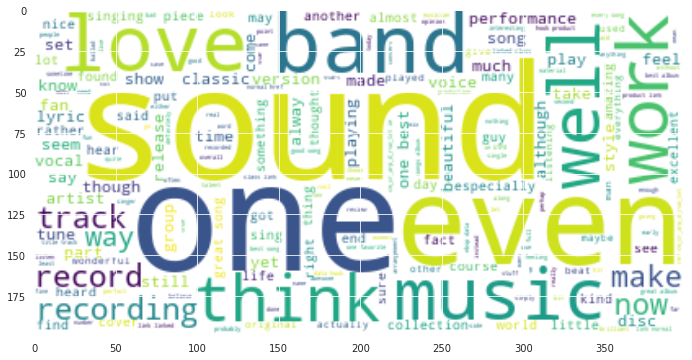

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.imshow(wordcloud_review, interpolation='bilinear')

In [ ]:
# WordCloud on Summary
summary_text = ' '.join(review for review in (train_df.summary))
wordcloud_summary = WordCloud(
     background_color='#FFFFFF',
     scale=1).generate(summary_text)

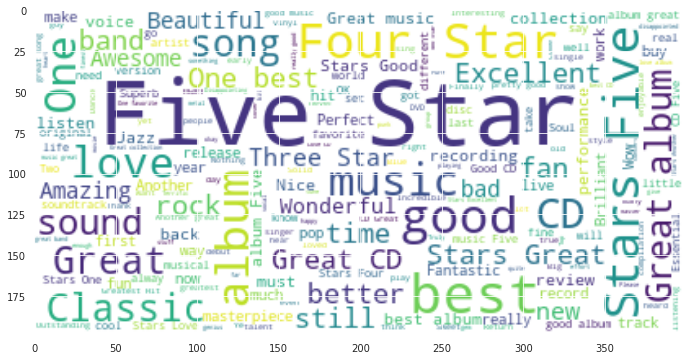

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.imshow(wordcloud_summary, interpolation='bilinear')

## Data Preprocessing

ReviewText and Summary are used to predict the rating. <br> 
**Cleaning procedures**: 
1. Make words to lowercase
2. Remove stopwords  
3. Remove punctuations
4. Stemming 

In [ ]:
# Make all characters in lowercase 
def lowercase(text): 
    return text.lower()

In [ ]:
# Remove punctuation
def remove_punct(text):
    exclude = set(string.punctuation)
    result = [char for char in text if char not in exclude]
    return ''.join(result)

In [ ]:
# Remove stop words 
def remove_stopwords(text): 
    text_tokens = word_tokenize(text)
    result = [word for word in text_tokens if word not in stopwords.words('english')]
    return ' '.join(result)

In [ ]:
# Stemming 
def stemming(text):
 stemmer = SnowballStemmer('english')
 result = [stemmer.stem(word) for word in text]
 return ''.join(result) 

In [ ]:
# Chain functions 
def preprocess(text):
  result = lowercase(text)
  result = remove_stopwords(result)
  result = remove_punct(result)
  result = stemming(result)
  return result

In [ ]:
# Implement preprocess
train_df['cleaned_summary'] = train_df['summary'].apply(lambda x: preprocess(x))
train_df['cleaned_review'] = train_df['reviewText'].apply(lambda x: preprocess(x))
test_df['cleaned_summary'] = test_df['summary'].apply(lambda x: preprocess(x))
test_df['cleaned_review'] = test_df['reviewText'].apply(lambda x: preprocess(x))

In [ ]:
# Save as csv (not necessary, just for ease of computation)
train_df.to_csv('/content/drive/My Drive/preprocess_train.csv')
test_df.to_csv('/content/drive/My Drive/preprocess_test.csv')

## Model Preparation on ReviewText

In [36]:
# Import preprocessed csv
train_df = pd.read_csv("/content/drive/My Drive/preprocess_train.csv", usecols=['reviewerID','itemID','cleaned_review','cleaned_summary','overall'])
test_df = pd.read_csv("/content/drive/My Drive/preprocess_test.csv", usecols=['reviewerID','itemID','cleaned_review','cleaned_summary'])

In [37]:
# Convert to string 
train_df.cleaned_summary = train_df.cleaned_summary.astype(str)
train_df.cleaned_review = train_df.cleaned_review.astype(str)
test_df.cleaned_summary = test_df.cleaned_summary.astype(str)
test_df.cleaned_review = test_df.cleaned_review.astype(str)

In [38]:
# Define inputs X and output y
X = train_df.cleaned_review
y = train_df.overall

In [39]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Encode on ReviewText with TF-IDF

In [41]:
# Apply TF-IDF
tfidf = TfidfVectorizer()
X_train_fit = tfidf.fit_transform(X_train)
X_test_transform = tfidf.transform(X_test)

## Model Tuning and Implementation on ReviewText
In total, four models are selected to implement both on reviewText and summary. The simple classification models, LinearSVC and Ordinal Logistic Regression, producing prediction with high bias but low variance. On the other hand, the complex models, LightGBM and XGBoost, producing prediction with low bias but high variance. By ensembling four models, we aim to obtain a new model predicts with moderate bias and variance. 

### LinearSVC

In [ ]:
# LinearSVC grid search tuning 
parameters = {'C':[0.001, 0.005, 0.01, 0.1, 0, 1, 10, 100]}

model = LinearSVC(random_state=0, tol=1e-5)
clf = GridSearchCV(model, parameters, scoring ='neg_mean_squared_error')
clf.fit(X_train_fit, y_train)

print('The best set of hyperparameters are:', clf.best_params_)
print('The best validation MSE:', clf.best_score_)

The best set of hyperparameters are: {'C': 1}
The best validation MSE: -0.8199714285714286


In [ ]:
# LinearSVC on train and validation 
svc = LinearSVC(C=1, random_state=0, tol=1e-5)
svc.fit(X_train_fit, y_train)
y_train_svc = svc.predict(X_train_fit)
y_test_svc = svc.predict(X_test_transform)

print('Training MSE', mean_squared_error(y_train, y_train_svc))
print('Test MSE:', mean_squared_error(y_test, y_test_svc))

Training MSE 0.28646666666666665
Test MSE: 0.8046222222222222


### Ordinal Logistic Regression

In [ ]:
# Manual Ordinal logistic regression tuning 

In [ ]:
def ordinal_logistic_regression(X_train, y_train, X_test, penalty_term, c):
    proba_list = [np.zeros(X_test.shape[0])]
    for i in range(4):
        y_train_copy = y_train.copy()

        y_train_copy[y_train_copy <= i+1] = 0
        y_train_copy[y_train_copy > i+1] = 1

        clf = LogisticRegression(class_weight='balanced',multi_class='multinomial',max_iter=500, penalty=penalty_term, C=c, random_state=0).fit(X_train, y_train_copy)
        proba = clf.predict_proba(X_test)
        proba_list.append(proba[:,0])
    proba_list.append(np.ones(X_test.shape[0]))
    
    proba_bucket_list = []
    for i in range(5):
        prob_bucket = proba_list[i+1] - proba_list[i]
        proba_bucket_list.append(prob_bucket)
    
    df_proba_bucket = pd.DataFrame(list(zip(proba_bucket_list[0],proba_bucket_list[1],proba_bucket_list[2],
                                    proba_bucket_list[3],proba_bucket_list[4])), 
                           columns=[1,2,3,4,5])
    
    return df_proba_bucket

In [ ]:
y_test_proba = ordinal_logistic_regression(X_train_fit,y_train, X_test_transform,'l2', 1)
y_train_proba = ordinal_logistic_regression(X_train_fit,y_train, X_train_fit,'l2', 1)

In [ ]:
y_test_ord = y_test_proba.idxmax(axis='columns')
y_train_ord = y_train_proba.idxmax(axis='columns')
print('Training MSE:', mean_squared_error(y_train, y_train_ord))
print('Test MSE:', mean_squared_error(y_test, y_test_ord))

Training MSE: 0.7473619047619048
Test MSE: 1.1118222222222223


In [ ]:
# Track ensemble 
print('Training MSE', mean_squared_error(y_train, (y_train_svc+y_train_ord)/2))
print('Test MSE:', mean_squared_error(y_test, (y_test_svc+y_test_ord)/2))

Training MSE 0.32795238095238094
Test MSE: 0.7044333333333334


### LightGBM

In [ ]:
# Lightgbm grid search tuning 
lgbrr = lgb.LGBMRegressor()
parameters = {'max_depth': [20,30,35],
              'learning_rate': [0.01, 0.15],
              'feature_fraction': [0.6,0.95]}
lgbrr_cv = GridSearchCV(lgbrr, parameters, cv=3, verbose=3, n_jobs=3, scoring ='neg_mean_squared_error')
lgbrr_cv.fit(X_train_fit, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 23.0min
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed: 32.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=3,
             param_grid={'feature_fraction': [0.6, 0.95],
                         'learning_rate': [0.01, 0.15],
                         'max_depth': [20, 30, 35]},
             pre

In [ ]:
print('The best set of hyperparameters are:', lgbrr_cv.best_params_)
print('The best validation MSE:', lgbrr_cv.best_score_)

The best set of hyperparameters are: {'feature_fraction': 0.6, 'learning_rate': 0.15, 'max_depth': 30}
The best validation MSE: -0.6173622026239423


In [ ]:
# LGBr on train and validation
lgbr = lgb.LGBMRegressor(feature_fraction = 0.6, learning_rate=0.15, max_depth=30)
lgbr.fit(X_train_fit,y_train)

y_train_lgbr = lgbr.predict(X_train_fit)
y_test_lgbr = lgbr.predict(X_test_transform)

print('Training MSE', mean_squared_error(y_train, y_train_lgbr))
print('Test MSE:', mean_squared_error(y_test, y_test_lgbr))

Training MSE 0.5311611689368393
Test MSE: 0.6110160611786772


In [ ]:
# Track ensemble 
print('Training MSE', mean_squared_error(y_train, (y_train_svc+y_train_ord+y_train_lgbr)/3))
print('Test MSE:', mean_squared_error(y_test, (y_test_svc+y_test_ord+y_test_lgbr)/3))

Training MSE 0.291217936680683
Test MSE: 0.578890249694227


### XGBoost

In [ ]:
# XGBoost grid search tuning 
model = xgboost.XGBRegressor()
parameters = {'booster':['gbtree','gblinear'],
             'learning_rate':[0.1,0.2,0.4],
             'max_depth':[2,3,6],
             'n_estimators':[100,500,1000]}
xgb_cv = GridSearchCV(model, parameters, cv=3, verbose=3, n_jobs=3, scoring ='neg_mean_squared_error')
xgb_cv.fit(X_train_fit, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 148.6min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 465.2min
[Parallel(n_jobs=3)]: Done 162 out of 162 | elapsed: 486.4min finished


[12:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=3,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.1, 0.2, 0.4],
                

In [ ]:
print('The best set of hyperparameters are:', xgb_cv.best_params_)
print('The best validation MSE:', xgb_cv.best_score_)

The best set of hyperparameters are: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
The best validation MSE: -0.6244177161204432


In [ ]:
# XGBoost on train and validation
xgb = xgboost.XGBRegressor(booster = 'gbtree', learning_rate=0.1, max_depth=6, n_estimators=1000)
xgb.fit(X_train_fit,y_train)

y_train_xgb = xgb.predict(X_train_fit)
y_test_xgb = xgb.predict(X_test_transform)

print('Training MSE', mean_squared_error(y_train, y_train_xgb))
print('Test MSE:', mean_squared_error(y_test, y_test_xgb))

[18:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training MSE 0.3782105726799296
Test MSE: 0.6113631816807343


In [ ]:
# Track ensemble
print('Training MSE', mean_squared_error(y_train, (((y_train_svc+y_train_ord)/2+(y_train_lgbr+y_train_xgb)/2)/2)))
print('Test MSE:', mean_squared_error(y_test, (((y_test_svc+y_test_ord)/2+(y_test_lgbr+y_test_xgb)/2)/2)))

Training MSE 0.2829415527880901
Test MSE: 0.5483525264439576


## Use ReivewText to make predictions on test csv

In [ ]:
X = test_df.cleaned_review

In [ ]:
X_transform = tfidf.transform(X)

In [ ]:
# Ordinal Logistic Regression 
y_prob = ordinal_logistic_regression(X_train_fit,y_train, X_transform,'l2', 1)
y_ord = y_prob.idxmax(axis='columns')

In [ ]:
# Linear SVC
y_svc = svc.predict(X_transform)

In [ ]:
# XGBoost
y_xgb = xgb.predict(X_transform)

In [ ]:
# LightGBM 
y_lgbr = lgbr.predict(X_transform)

In [ ]:
test_df['ord'] = y_ord
test_df['svc'] = y_svc
test_df['xgb'] = y_xgb
test_df['lgbr'] = y_lgbr

In [ ]:
test_df['userID-itemID'] = test_df[['reviewerID', 'itemID']].agg('-'.join, axis=1)

In [ ]:
test_df.set_index('userID-itemID', inplace=True)

In [ ]:
test_df.head()

## Model Preparation on Summary

In [ ]:
X_sum = train_df.cleaned_summary
y_sum = train_df.overall

In [ ]:
# Train test split
X_sum_train, X_sum_test, y_sum_train, y_sum_test = train_test_split(X_sum, y_sum, test_size=0.3, random_state=1)

### Encode on Summary with TF-IDF

In [ ]:
# Apply TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_sum_train_fit = tfidf.fit_transform(X_sum_train)
X_sum_test_transform = tfidf.transform(X_sum_test)

## Model Tuning and Implementation on Summary

### LinearSVC

In [ ]:
# LinearSVC grid search tuning 
parameters = {'C':[0.001, 0.005, 0.01, 0.1, 0, 1, 10, 100]}

model = LinearSVC(random_state=0, tol=1e-5)
clf = GridSearchCV(model, parameters, scoring ='neg_mean_squared_error')
clf.fit(X_sum_train_fit, y_sum_train)

print('The best set of hyperparameters are:', clf.best_params_)
print('The best validation MSE:', clf.best_score_)

The best set of hyperparameters are: {'C': 1}
The best validation MSE: -0.944


In [ ]:
# LinearSVC on train and validation
svc_sum = LinearSVC(C=1, random_state=0, tol=1e-5)
svc_sum.fit(X_sum_train_fit, y_sum_train)
y_sum_train_svc = svc_sum.predict(X_sum_train_fit)
y_sum_test_svc = svc_sum.predict(X_sum_test_transform)

print('Training MSE', mean_squared_error(y_sum_train, y_sum_train_svc))
print('Test MSE:', mean_squared_error(y_sum_test, y_sum_test_svc))

Training MSE 0.16508571428571428
Test MSE: 0.9022888888888889


In [ ]:
# Track ensemble 
print('Training MSE', mean_squared_error(y_train, (((y_sum_train_svc+y_train_svc+y_train_ord)/3+(y_train_lgbr+y_train_xgb)/2)/2)))
print('Test MSE:', mean_squared_error(y_test, (((y_sum_test_svc+y_test_svc+y_test_ord)/3+(y_test_lgbr+y_test_xgb)/2)/2)))

Training MSE 0.24754386613984655
Test MSE: 0.5122871574727837


### Ordinal Logistic Regression

In [ ]:
y_sum_test_proba = ordinal_logistic_regression(X_sum_train_fit,y_sum_train, X_sum_test_transform,'l2', 10)
y_sum_train_proba = ordinal_logistic_regression(X_sum_train_fit,y_sum_train, X_sum_train_fit,'l2', 10)
y_sum_test_ord = y_sum_test_proba.idxmax(axis='columns')
y_sum_train_ord = y_sum_train_proba.idxmax(axis='columns')
print('The training MSE:', mean_squared_error(y_sum_train, y_sum_train_ord))
print('The test MSE:', mean_squared_error(y_sum_test, y_sum_test_ord))

The training MSE: 0.29851428571428573
The test MSE: 1.2586


In [ ]:
# Check ensemble 
print('Training MSE', mean_squared_error(y_train, (((y_sum_train_svc+y_sum_train_ord+y_train_svc+y_train_ord)/4+(y_train_lgbr+y_train_xgb)/2)/2)))
print('Test MSE:', mean_squared_error(y_test, (((y_sum_test_svc+y_sum_test_ord+y_test_svc+y_test_ord)/4+(y_test_lgbr+y_test_xgb)/2)/2)))

Training MSE 0.22499096783781936
Test MSE: 0.5001891755697839


### LightGBM

In [ ]:
# Lightgbm grid search tuning 
lgbrr = lgb.LGBMRegressor()
parameters = {'max_depth': [20,25,30],
              'learning_rate': [0.1, 0.15,0.3,0.5],
              'feature_fraction': [0.6,0.95]}
lgbrr_cv = GridSearchCV(lgbrr, parameters, cv=3, verbose=3, n_jobs=3, scoring ='neg_mean_squared_error')
lgbrr_cv.fit(X_sum_train_fit, y_sum_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=3,
             param_grid={'feature_fraction': [0.6, 0.95],
                         'learning_rate': [0.1, 0.15, 0.3, 0.5],
                         'max_depth': [20, 25, 30]},
       

In [ ]:
print('The best set of hyperparameters are:', lgbrr_cv.best_params_)
print('The best validation MSE:', lgbrr_cv.best_score_)

The best set of hyperparameters are: {'feature_fraction': 0.95, 'learning_rate': 0.3, 'max_depth': 30}
The best validation MSE: -0.7127497789541094


In [ ]:
# LGBr on train and validation
lgbr_sum = lgb.LGBMRegressor(feature_fraction = 0.95, learning_rate=0.3, max_depth=30)
lgbr_sum.fit(X_sum_train_fit,y_sum_train)

y_sum_train_lgbr = lgbr_sum.predict(X_sum_train_fit)
y_sum_test_lgbr = lgbr_sum.predict(X_sum_test_transform)

print('Training MSE', mean_squared_error(y_sum_train, y_sum_train_lgbr))
print('Test MSE:', mean_squared_error(y_sum_test, y_sum_test_lgbr))

Training MSE 0.641314098524557
Test MSE: 0.7019661316522372


In [ ]:
# Check ensemble 
print('Training MSE', mean_squared_error(y_train, (((y_sum_train_svc+y_sum_train_ord+y_train_svc+y_train_ord)/4+(y_train_lgbr+y_train_xgb+y_sum_train_lgbr)/3)/2)))
print('Test MSE:', mean_squared_error(y_test, (((y_sum_test_svc+y_sum_test_ord+y_test_svc++y_test_ord)/4+(y_test_lgbr+y_test_xgb+y_sum_test_lgbr)/3)/2)))

Training MSE 0.22475585350819244
Test MSE: 0.4959889853474797


### XGBoost

In [ ]:
# XGBoost grid search tuning 
model = xgboost.XGBRegressor()
parameters = {'booster':['gbtree','gblinear'],
             'learning_rate':[0.2,0.4,0.6],
             'max_depth':[6,10,15],
             'n_estimators':[100,300,500]}
xgb_cv = GridSearchCV(model, parameters, cv=3, verbose=3, n_jobs=3, scoring ='neg_mean_squared_error')
xgb_cv.fit(X_sum_train_fit, y_sum_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 78.4min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 235.1min
[Parallel(n_jobs=3)]: Done 162 out of 162 | elapsed: 238.5min finished


[07:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=3,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.2, 0.4, 0.6],
                

In [ ]:
print('The best set of hyperparameters are:', xgb_cv.best_params_)
print('The best validation MSE:', xgb_cv.best_score_)

The best set of hyperparameters are: {'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 500}
The best validation MSE: -0.6911166089215576


In [ ]:
# XGBoost on train and validation
xgb_sum = xgboost.XGBRegressor(booster = 'gbtree', learning_rate=0.2, max_depth=10, n_estimators=500)
xgb_sum.fit(X_sum_train_fit,y_sum_train)

y_sum_train_xgb = xgb_sum.predict(X_sum_train_fit)
y_sum_test_xgb = xgb_sum.predict(X_sum_test_transform)

print('Training MSE', mean_squared_error(y_sum_train, y_sum_train_xgb))
print('Test MSE:', mean_squared_error(y_sum_test, y_sum_test_xgb))

[17:50:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training MSE 0.4871219556898899
Test MSE: 0.6838694847076336


In [ ]:
# Check ensemble 
print('Training MSE', mean_squared_error(y_train, (((y_sum_train_svc+y_sum_train_ord+y_train_svc+y_train_ord)/4+(y_train_lgbr+y_train_xgb+y_sum_train_lgbr+y_sum_train_xgb)/4)/2)))
print('Test MSE:', mean_squared_error(y_test, (((y_sum_test_svc+y_sum_test_ord+y_test_svc++y_test_ord)/4+(y_test_lgbr+y_test_xgb+y_sum_test_lgbr+y_sum_test_xgb)/4)/2)))

## Summarize Results and Analysis

**Classification on ReviewText**

In [ ]:
print('Training MSE', mean_squared_error(y_train, (y_train_svc+y_train_ord)/2))
print('Test MSE:', mean_squared_error(y_test, (y_test_svc+y_test_ord)/2))

Training MSE 0.32795238095238094
Test MSE: 0.7044333333333334


**Regression on ReviewText**

In [ ]:
print('Training MSE', mean_squared_error(y_train, (y_train_lgbr+y_train_xgb)/2))
print('Test MSE:', mean_squared_error(y_test, (y_test_lgbr+y_test_xgb)/2))

Training MSE 0.44337940628995587
Test MSE: 0.6017349384391721


**Classification on Summary**

In [ ]:
print('Training MSE', mean_squared_error(y_train, (y_sum_train_ord+y_sum_train_svc)/2))
print('Test MSE:', mean_squared_error(y_test, (y_sum_test_ord+y_sum_test_svc)/2))

Training MSE 0.14752380952380953
Test MSE: 0.8844666666666666


**Regression on Summary**

In [ ]:
print('Training MSE', mean_squared_error(y_train, (y_sum_train_lgbr+y_sum_train_xgb)/2))
print('Test MSE:', mean_squared_error(y_test, (y_sum_test_lgbr+y_sum_test_xgb)/2))

Training MSE 0.5491469150712467
Test MSE: 0.6759056361618028


**Ensemble Weights Tuning**

In [ ]:
# Take average over 8 models 
print('Training MSE', mean_squared_error(y_train, (y_sum_train_ord+y_sum_train_svc+y_train_svc+y_train_ord+y_train_lgbr+y_train_xgb+y_sum_train_lgbr+y_sum_train_xgb)/8))
print('Test MSE:', mean_squared_error(y_test, (y_sum_test_ord+y_sum_test_svc+y_test_svc+y_test_ord+y_test_lgbr+y_test_xgb+y_sum_test_lgbr+y_sum_test_xgb)/8))

Training MSE 0.1905575052617377
Test MSE: 0.4871476603540545


In [ ]:
X_train_ensemble = pd.DataFrame(data = zip(y_train_ord, y_train_svc, y_train_lgbr,y_train_xgb, y_sum_train_ord, y_sum_train_svc, y_sum_train_lgbr, y_sum_train_xgb,y_train))
X_test_ensemble = pd.DataFrame(data = zip(y_test_ord, y_test_svc, y_test_lgbr,y_test_xgb, y_sum_test_ord, y_sum_test_svc, y_sum_test_lgbr, y_sum_test_xgb,y_test))

In [ ]:
X_train_ensemble.rename(columns = {0:'ord',1:'svc',2:'lgbr',3:'xgb',4:'sum_ord',5:'sum_svc',6:'sum_lgbr',7:'sum_xgb',8:'overall'}, inplace=True)

In [ ]:
X_test_ensemble.rename(columns = {0:'ord',1:'svc',2:'lgbr',3:'xgb',4:'sum_ord',5:'sum_svc',6:'sum_lgbr',7:'sum_xgb',8:'overall'}, inplace=True)

In [ ]:
X_train_ensemble.to_csv('/content/drive/My Drive/train_ensemble.csv')

In [ ]:
X_test_ensemble.to_csv('/content/drive/My Drive/test_ensemble.csv')

## Use Summary to make predictions on test csv

In [ ]:
X_sum = test_df.cleaned_summary
X_sum_transform = tfidf.transform(X_sum)

In [ ]:
# Ordinal Logistic Regression 
y_sum_prob = ordinal_logistic_regression(X_sum_train_fit, y_sum_train, X_sum_transform,'l2', 1)
y_sum_ord = y_sum_prob.idxmax(axis='columns')

In [ ]:
# Linear SVC
y_sum_svc = svc_sum.predict(X_sum_transform)

In [ ]:
# XGBoost
y_sum_xgb = xgb_sum.predict(X_sum_transform)

In [ ]:
# LightGBM 
y_sum_lgbr = lgbr_sum.predict(X_sum_transform)

In [ ]:
test_df['ord_sum'] = y_sum_ord.tolist()
test_df['svc_sum'] = y_sum_svc
test_df['xgb_sum'] = y_sum_xgb
test_df['lgbr_sum'] = y_sum_lgbr

In [ ]:
test_df.head()

,reviewerID,itemID,cleaned_summary,cleaned_review,pred,ord,nb,svc,xgb,lgbr,ord_sum,nb_sum,svc_sum,xgb_sum,lgbr_sum
userID-itemID,,,,,,,,,,,,,,,
u04140621-p65721979,u04140621,p65721979,five stars,ok,0.0,3,3.0,3.0,4.019560,3.965507,5,5.0,5.0,5.003895,4.990097
u74766187-p87809670,u74766187,p87809670,buy 1955 set monk,1955 1958 sets alone worth purchase cost ever...,0.0,5,5.0,5.0,4.718931,4.700517,5,5.0,5.0,4.559235,4.540289
u31689638-p52702240,u31689638,p52702240,mary s excellent debut classic,mary j blige someone people know first appear...,0.0,4,4.0,4.0,4.380852,4.660523,5,5.0,5.0,4.837933,4.728152
u35613516-p01314374,u35613516,p01314374,four stars,good satch album,0.0,5,5.0,5.0,4.540334,4.520506,4,4.0,4.0,4.037926,3.998647
u93320378-p84396269,u93320378,p84396269,cd lives name,well hundreds christmas anthologies one best ...,0.0,5,5.0,5.0,4.861528,4.922900,5,5.0,5.0,4.528360,4.680853


In [ ]:
test_df['prediction'] = ((test_df.loc[:,['ord','svc','ord_sum','svc_sum']].mean(axis=1) + test_df.loc[:,['xgb','lgbr','xgb_sum','lgbr_sum']].mean(axis=1))/2)

In [ ]:
test_df['prediction'].to_csv('/content/drive/My Drive/predictions.csv')

In [ ]:
test_df['prediction'].head()

userID-itemID
u04140621-p65721979    4.247382
u74766187-p87809670    4.814871
u31689638-p52702240    4.575932
u35613516-p01314374    4.387177
u93320378-p84396269    4.874205
Name: prediction, dtype: float64